### Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

## Подготовка

Загрузка датасета 

In [1]:
import pandas as pd
df = pd.read_csv('GM_players_statistics.csv')

Заполнение пропусков для числовых колонок

In [2]:
# Выберем числовые колонки

num_cols = []
for col in df.columns:
    # Количество пустых значений 
    temp_null_count = df[df[col].isnull()].shape[0]
    dt = str(df[col].dtype)
    if dt=='float64' or dt=='int64':
        num_cols.append(col)

In [3]:
# Заполнение пропусков для числовных колонок
from sklearn.impute import SimpleImputer

for col in df[num_cols]:
    imp_num = SimpleImputer(strategy='mean')
    data_num_imp = imp_num.fit_transform(df[[col]])
    df[[col]] = data_num_imp

Заполнение пропусков для колонки `league`

In [4]:
imp_num = SimpleImputer(strategy='most_frequent')
data_num_imp = imp_num.fit_transform(df[['league']])
df[['league']] = data_num_imp

Кодирование категориального признака `league` (Bronze/Silver/...)

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cat_enc_le = le.fit_transform(df['league'])
df['league_coded'] = cat_enc_le

## Разбиение на обучающую и тестовые выборки

In [6]:
from sklearn.model_selection import train_test_split

x_df = df[num_cols] # числовые колонки

y_df = df['league_coded'] # колонка с закодированной лигой

x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.25, random_state=42)

## Обучение модели ближайших соседей

Обучение модели с гиперпараметром K=5

In [7]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(x_train, y_train)
y_test_predict = knn_classifier.predict(x_test)
y_train_predict = knn_classifier.predict(x_train)

## Оценка качества модели

In [8]:
from sklearn.metrics import accuracy_score
import numpy as np

accuracy_score(y_test, y_test_predict), accuracy_score(y_train, y_train_predict)

(0.26790450928381965, 0.46419098143236076)

## Кросс-валидация

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), x_df, y_df, cv=5)
scores, np.mean(scores)

(array([0.30794702, 0.22516556, 0.17880795, 0.21594684, 0.20265781]),
 0.22610503619282304)

Метрика f1

In [10]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), 
                         x_df, y_df, cv=5,
                        scoring='f1_weighted')
scores, np.mean(scores)

(array([0.28396336, 0.21763724, 0.17873788, 0.21228775, 0.2002749 ]),
 0.21858022623212597)

In [11]:
from sklearn.model_selection import cross_validate

scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        x_df, y_df, scoring=scoring, 
                        cv=5, return_train_score=True)
scores

C:\Users\Konstantin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Konstantin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'fit_time': array([0.00484157, 0.00357151, 0.00300026, 0.        , 0.00515366]),
 'score_time': array([0.04180741, 0.04513264, 0.03651357, 0.0502727 , 0.03782749]),
 'test_precision': array([0.24437143, 0.2102494 , 0.19628836, 0.22856955, 0.16280053]),
 'train_precision': array([0.67075143, 0.67642156, 0.68883285, 0.68279116, 0.68524907]),
 'test_recall': array([0.2615894 , 0.20529801, 0.17880795, 0.20265781, 0.15614618]),
 'train_recall': array([0.60364842, 0.60945274, 0.62271973, 0.61723281, 0.61143331]),
 'test_f1': array([0.24724291, 0.20518239, 0.17877391, 0.20019491, 0.15292243]),
 'train_f1': array([0.56696406, 0.57882096, 0.59171186, 0.58037097, 0.57525784])}

## Подбор гиперпараметра K 

`GridSearchCV`

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [x for x in range(1, 100)]} 

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1_macro')
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='f1_macro')

In [13]:
grid.cv_results_

{'mean_fit_time': array([0.00279551, 0.00132565, 0.0024261 , 0.00230412, 0.00226922,
        0.00154505, 0.00137544, 0.00042009, 0.        , 0.00028477,
        0.        , 0.00275464, 0.00054822, 0.00382681, 0.00050988,
        0.00034027, 0.        , 0.00043335, 0.0043293 , 0.00166125,
        0.00135236, 0.        , 0.00017414, 0.        , 0.0030869 ,
        0.00017705, 0.00158243, 0.00513172, 0.0020431 , 0.00072184,
        0.00210118, 0.00120068, 0.00221395, 0.00028706, 0.00269504,
        0.00240359, 0.0035481 , 0.00309668, 0.00134788, 0.00665455,
        0.00281181, 0.        , 0.00396214, 0.0030755 , 0.00435753,
        0.00591931, 0.00300665, 0.00312963, 0.00613236, 0.        ,
        0.00215082, 0.00312953, 0.00219283, 0.002807  , 0.00602307,
        0.00130296, 0.        , 0.00380721, 0.0062552 , 0.00108991,
        0.00250492, 0.00555882, 0.00625391, 0.00251112, 0.0013185 ,
        0.00412912, 0.        , 0.        , 0.00026898, 0.00312934,
        0.00312552, 0.00312853,

In [14]:
# Лучшая модель
grid.best_estimator_

KNeighborsClassifier(n_neighbors=13)

In [15]:
# Лучшее значение метрики
grid.best_score_

0.11804143964461988

In [16]:
# Лучшее значение параметров
grid.best_params_

{'n_neighbors': 13}

Изменение качества на тестовой выборке в зависимости от К-соседей

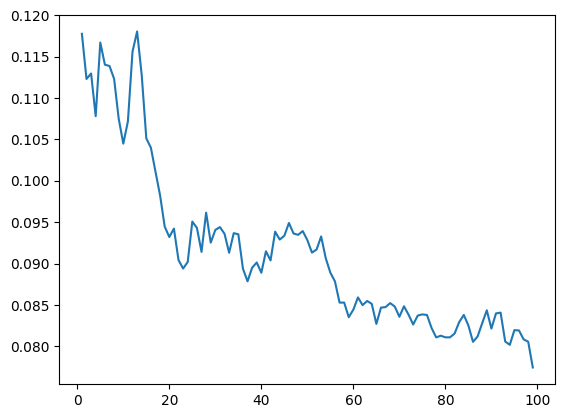

In [17]:
import matplotlib.pyplot as plt

plt.plot(param_grid['n_neighbors'], grid.cv_results_['mean_test_score'])

`RandomizedSearchCV`

In [18]:
from sklearn.model_selection import RandomizedSearchCV

clf_rs = RandomizedSearchCV(KNeighborsClassifier(), [param_grid], n_iter=len(param_grid['n_neighbors']), cv=5, scoring='f1_macro')
clf_rs.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=99,
                   param_distributions=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, 28, 29, 30, ...]}],
                   scoring='f1_macro')

In [19]:
grid.best_score_, grid.best_params_

(0.11804143964461988, {'n_neighbors': 13})

In [20]:
clf_rs.best_score_, clf_rs.best_params_

(0.11804143964461988, {'n_neighbors': 13})

In [21]:
clf_rs.cv_results_

{'mean_fit_time': array([0.00220919, 0.00625315, 0.00191002, 0.00625839, 0.00876303,
        0.00312433, 0.00312691, 0.        , 0.00110793, 0.        ,
        0.00312986, 0.00150247, 0.        , 0.00313182, 0.        ,
        0.00312924, 0.        , 0.00041857, 0.00501242, 0.00331993,
        0.00312104, 0.        , 0.00513625, 0.        , 0.00312667,
        0.003128  , 0.00439577, 0.00350504, 0.00362921, 0.00142326,
        0.00395274, 0.00333495, 0.        , 0.00131116, 0.00312881,
        0.00313525, 0.00573053, 0.00312529, 0.00353675, 0.00108838,
        0.00058608, 0.00625424, 0.00228429, 0.00143871, 0.00433497,
        0.        , 0.00938902, 0.00355601, 0.00625305, 0.        ,
        0.00312629, 0.00440903, 0.00298958, 0.00588384, 0.00423484,
        0.00060973, 0.        , 0.        , 0.00313611, 0.        ,
        0.00312819, 0.        , 0.0089572 , 0.00220423, 0.00625439,
        0.        , 0.00095634, 0.        , 0.        , 0.00312634,
        0.        , 0.00180287,

Изменение качества на тестовой выборке в зависимости от К-соседей

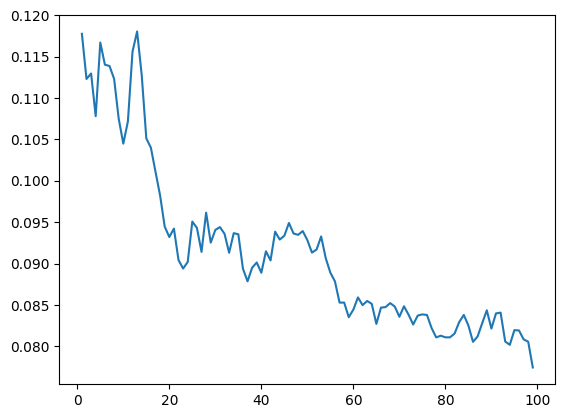

In [22]:
plt.plot(param_grid['n_neighbors'], clf_rs.cv_results_['mean_test_score'])

In [23]:
grid.best_estimator_.fit(x_train, y_train)
target2_0 = grid.best_estimator_.predict(x_train)
target2_1 = grid.best_estimator_.predict(x_test)

## Сравнение нового и старого качества моделей

In [24]:
# Новое качество модели
accuracy_score(y_train, target2_0), accuracy_score(y_test, target2_1)

(0.41379310344827586, 0.3395225464190981)

In [25]:
# Старое качество
accuracy_score(y_test, y_test_predict), accuracy_score(y_train, y_train_predict)

(0.26790450928381965, 0.46419098143236076)